## Статистический анализ выборок в задаче кредитного скоринга

In [1]:
import numpy as np
import pandas as pd

from statsmodels.stats.weightstats import *

In [2]:
from scipy.stats import norm
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/ds/.local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
from statsmodels.sandbox.stats.multicomp import multipletests 

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import statsmodels
import scipy as sc
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2

In [7]:
# загружаем данные о кредитных историях
cards = pd.read_csv('credit_card_default_analysis.csv', index_col='ID')
cards.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,0,0,0,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,0,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,0,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [8]:
cards.shape

(30000, 24)

### Задача 1

Проверка гипотезы Но - для вернувших и не вернувших кредиты медианы кредитного лимита совпадают.
Альтернатива - не совпадают.

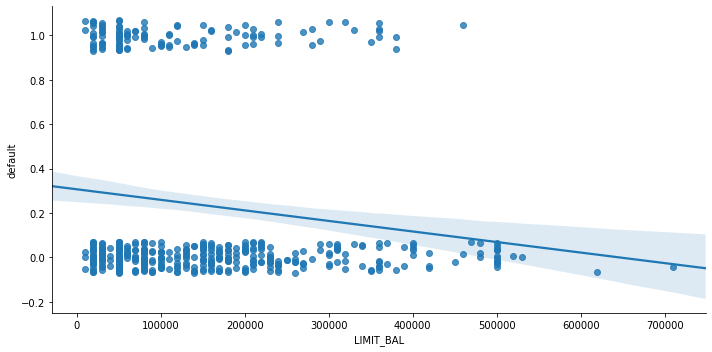

In [12]:
peta = [np.random.randint(0, cards.shape[0]) for x in range(500)]   # можно построить гистограммы или еще seaborn.kdeplot(data[data['default']==0].LIMIT_BAL,shade=True,label='default=0')
s_cards = cards.iloc[peta, :]
sns.lmplot(y='default', x='LIMIT_BAL', data=s_cards, y_jitter=0.07, aspect=2)

Визуально у вернувших кредит более высокие значения лимита баланса. И их в принципе гораздо больше

In [13]:
cards_0 = cards[cards.default == 0]
cards_1 = cards[cards.default == 1]

Точечная оценка медианы для двух групп

In [14]:
print('Медиана для вернувших', cards_0.LIMIT_BAL.median(), ', Медиана для не вернувших', cards_1.LIMIT_BAL.median())

Медиана для вернувших 150000.0 , Медиана для не вернувших 90000.0


In [15]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

Интервальная оценка

In [16]:
np.random.seed(0)

def0_median_scores = list(map(np.median, get_bootstrap_samples(cards_0.LIMIT_BAL.values, 1000)))
def1_median_scores = list(map(np.median, get_bootstrap_samples(cards_1.LIMIT_BAL.values, 1000)))

print("95% доверительный интервал для медианы лимита вернувших:",  stat_intervals(def0_median_scores, 0.05))
print("95% доверительный интервал для медианы лимита не вернувших:",  stat_intervals(def1_median_scores, 0.05))

95% доверительный интервал для медианы лимита вернувших: [150000. 150000.]
95% доверительный интервал для медианы лимита не вернувших: [80000. 90000.]


In [17]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(def0_median_scores, def1_median_scores)))

In [18]:
print("95% доверительный интервал для разности медиан",  stat_intervals(delta_median_scores, 0.05))

95% доверительный интервал для разности медиан [-70000. -60000.]


Оценка не включает ноль, что говорит о статистически значимых различиях для медиан

Проверка посредством непараметрического критерия Манна-Уитни:

In [20]:
stats.mannwhitneyu(cards_0.LIMIT_BAL, cards_1.LIMIT_BAL)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

pvalue меньше 0.05, таким образом можно отвергнуть нулевую гипотезу о равенстве средних

При этом практическая значимость такого результата неочевидна. Разумно, что банк принимает решение о размере лимита на основе оценки рисков для каждого клиента. С этой позиции неудивительно, что люди с меньшим лимитом (то есть более рисковые заемщики) чаще не возвращают кредит. Но странно было бы предположить, что увеличив таким людям 
лимит, можно добиться большей возвращаемости кредитов. Вероятно, это лишь косвенно указывает на то, что система определения рисков и размера лимита работает правильно.

### Зачада 2

Проверка гипотезы Но - доли мужчин и женщин, не вернувших кредиты, не различаются.
Альтернатива - различаются.

In [ ]:
cards_m = cards[cards.SEX == 1]
cards_f = cards[cards.SEX == 2]

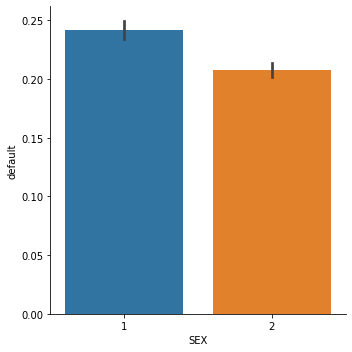

In [35]:
sns.catplot(x="SEX", y="default", kind="bar", data=cards);

По графику мужчины несколько чаще не возвращают кредиты

In [45]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = sc.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):  
    if alternative == 'two-sided':
        return 2 * (1 - sc.stats.norm.cdf(np.abs(z_stat)))

In [46]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(cards_m.default, cards_f.default))

95% confidence interval for a difference between proportions: [0.024207, 0.043612]


In [47]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(cards_m.default, cards_f.default)))

p-value: 0.000000


Доверительный интервал для разности долей не включает ноль, и достигаемый уровень значимости меньше 0.05,
следовательно, можно отвергнуть нулевую гипотезу. 
Из этого можно сделать вывод, что мужчины чаще не возвращают кредиты.

### Задача 3
Проверка взаимосвязи образования и возврата кредитов

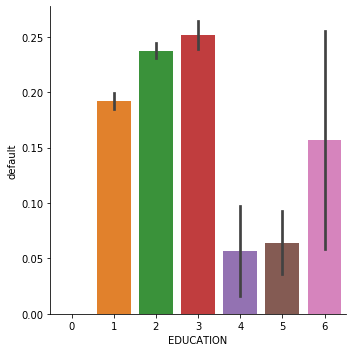

In [129]:
sns.catplot(x="EDUCATION", y="default", kind="bar", data=cards)

In [155]:
cards.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [156]:
educ_list = []

for e in sort(cards.EDUCATION.unique()):
    educ_list.append(cards[cards.EDUCATION == e].default.values)

In [167]:
table = []

for q in educ_list:
    table.append([sum(q), q.size-sum(q)])

In [168]:
table 

[[0, 14],
 [2036, 8549],
 [3330, 10700],
 [1237, 3680],
 [7, 116],
 [18, 262],
 [8, 43]]

In [159]:
hi2, p, dof, ex = stats.chi2_contingency(table) 
print(hi2, p)

163.21655786997073 1.2332626245415605e-32


In [160]:
np.sqrt(hi2/(sum(table)*(2-1)))

0.07376009713252163

Статистически значимая зависимость есть, но коэффициент крамера близок к нулю, 
следовательно она незначительная.

Судя по графику, лучше всего возвращают кредиты представители 4 и 5 категории. Но по ним 
относительно мало данных. 

### Задача 4
Проверка взаимосвязи семейного положения и возврата кредитов

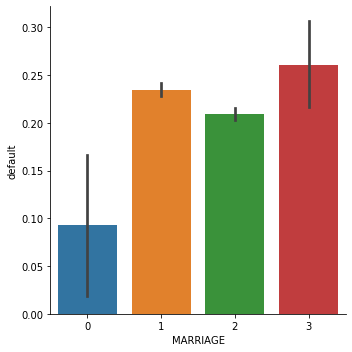

In [80]:
sns.catplot(x="MARRIAGE", y="default", kind="bar", data=cards)

Используем коэффициент Крамера

In [109]:
sort(cards.MARRIAGE.unique())

array([0, 1, 2, 3])

In [120]:
mar_list = []

for m in sort(cards.MARRIAGE.unique()):
    mar_list.append(cards[cards.MARRIAGE == m].default.values)

In [121]:
table2 = []

for st in mar_list:
    table2.append([sum(st), st.size-sum(st)])

In [122]:
table2

[[5, 49], [3206, 10453], [3341, 12623], [84, 239]]

In [123]:
hi2, p, dof, ex = stats.chi2_contingency(table2) 
print(hi2, p)

35.66239583433609 8.825862457577375e-08


In [124]:
np.sqrt(hi2/(sum(table2)*(2-1)))

0.034478203662766466

Значение коэффициента Крамера близко к нулю, следовательно, зависимость есть, но незначительная

### Задача 5

Проверка гипотезы Но - для вернувших и не вернувших кредиты средние значения возраста совпадают.
Альтернатива - не совпадают.

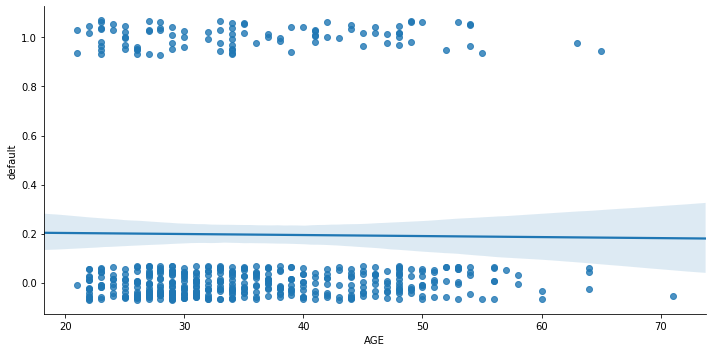

In [63]:
peta = [np.random.randint(0, cards.shape[0]) for x in range(500)]
s_cards = cards.iloc[peta, :]
sns.lmplot(y='default', x='AGE', data=s_cards, y_jitter=0.07, aspect=2)

Визуально средний возраст не отличается

Точечная оценка среднего:

In [64]:
print('Средний возраст для вернувших', cards_0.AGE.mean(), 'Для не вернувших', cards_1.AGE.mean())

Средний возраст для вернувших 35.417265879130284 Для не вернувших 35.72573839662447


In [76]:
np.random.seed(0)

def0_mean_scores = list(map(np.mean, get_bootstrap_samples(cards_0.AGE.values, 1000)))
def1_mean_scores = list(map(np.mean, get_bootstrap_samples(cards_1.AGE.values, 1000)))

print("95% доверительный интервал для среднего возраста вернувших:",  stat_intervals(def0_mean_scores, 0.05))
print("95% доверительный интервал для среднего возраста не вернувших:",  stat_intervals(def1_mean_scores, 0.05))

95% доверительный интервал для среднего возраста вернувших: [35.30182867 35.53313966]
95% доверительный интервал для среднего возраста не вернувших: [35.49975512 35.95544002]


In [77]:
delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(def0_mean_scores, def1_mean_scores)))

In [78]:
print("95% доверительный интервал для разности средних",  stat_intervals(delta_mean_scores, 0.05))

95% доверительный интервал для разности средних [0.05203262 0.5645032 ]


In [69]:
stats.mannwhitneyu(cards_0.AGE, cards_1.AGE)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

Интервальные оценки пересекаются, хотя доверительный интервал для разности средних не включает ноль.
При этом непараметрический критерий Мана-Уитни дает значение для pvalue больше 0.05, что не
позволяет отвергнуть нулевую гипотезу о равенстве средних.